## Load API keys needed for Elsevier and Dropbox

Set the API keys in [api_keys.ipynb](api_keys.ipynb).

In [1]:
#%run api_keys.ipynb

### Connect to Scopus

In [2]:
#%run scopus.ipynb

## Obtain records

In [3]:
#scopus_query = "tourism+AND+innovation"

In [4]:
#data = scopus_retrive(scopus_query, save_to_file='tmp_all.csv')
#print('Documents loaded: {}'.format(len(data)))

## Preprocess

In [5]:
%run 04-preprocessing.ipynb

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/raztematike/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/raztematike/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
ignore_words = [
    "finding", "research", "purpose", "study", "methodology", "result", 
    "analysis", "method", "paper", "literature", "tourism", "tourist", "innovation",
    "also", "within", "whereas", "would", "br", "elsevier"
]

In [7]:
data = pd.read_json(open('data/scopus_data_2019-09-05-093052.json'), encoding='utf-8')

documents_tokens, data_preprocessed, bigram_lexicon = preprocess(data, to_ignore=ignore_words, save_to_file='tmp_preprocessed.csv')
print('Documents kept after preprocessing: {}'.format(len(documents_tokens)))

with open('Preprocess/tokens.pkl', 'wb') as handle:
    pickle.dump(documents_tokens, handle, protocol=pickle.HIGHEST_PROTOCOL)

Documents kept after preprocessing: 1782


## Basic statistics

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

### Word Frequencies

Find most frequent words in the corpus.

In [9]:
fdist = word_frequencies(documents_tokens)

Change `show_top_n` to adjust the number of words to display.

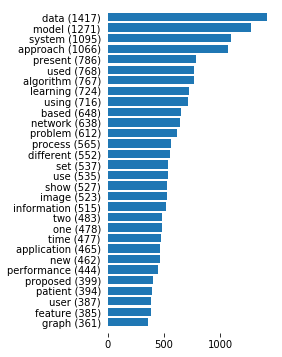

In [10]:
show_top_n = 30

# calc
mc = fdist.most_common(show_top_n)

# plot
mc = mc[::-1] ; ws, fs = zip(*mc) ; ws = ['{} ({})'.format(w, f) for w, f in mc]
plt.figure(figsize=(3, 6*show_top_n/30))
plt.box(False); plt.tick_params(top=False, bottom=True, left=False, right=False, labelleft=True, labelbottom=True)
plt.barh(range(len(ws)), fs) ; plt.yticks(range(len(ws)), ws); plt.ylim(-1, len(ws));

### Context of words

Find common contexts (co-occurring words) where the words from the list appear.

In [11]:
word_list = ['hotel', 'technology']

context = word_contexts(documents_tokens, word_list, num=20)

('The following word(s) were not found:', 'hotel technology')


## Topic discovery

In [12]:
%run "Topic Modeling/pyldavis.ipynb"

### Show topics and most frequently used words in each topic
Set `num_topics` to the expected number of topics in the corpus.

Set `num_words` to control the number of ***most frequent*** words listed for each topic.

In [13]:
num_topics = 7
num_words = 10

corpus, dictionary, ldamodel = pyldavis_prep(documents_tokens, num_topics=num_topics, num_words=num_words)

Topic 1:
   "system": 0.015
   "user": 0.007
   "process": 0.007
   "present": 0.006
   "software": 0.005
   "information": 0.005
   "recognition": 0.005
   "trust": 0.005
   "data": 0.005
   "model": 0.005
Topic 2:
   "graph": 0.015
   "data": 0.011
   "approach": 0.010
   "network": 0.009
   "system": 0.007
   "model": 0.006
   "present": 0.006
   "gene": 0.005
   "use": 0.004
   "problem": 0.004
Topic 3:
   "patient": 0.020
   "time": 0.006
   "disease": 0.005
   "pd": 0.005
   "treatment": 0.004
   "used": 0.004
   "motor": 0.004
   "image": 0.004
   "mrna": 0.004
   "symptom": 0.004
Topic 4:
   "data": 0.018
   "network": 0.012
   "system": 0.011
   "model": 0.010
   "learning": 0.007
   "decision": 0.007
   "process": 0.007
   "approach": 0.006
   "support": 0.006
   "information": 0.005
Topic 5:
   "learning": 0.009
   "model": 0.008
   "present": 0.008
   "data": 0.007
   "used": 0.007
   "algorithm": 0.007
   "approach": 0.006
   "system": 0.006
   "machine": 0.005
   "rule": 

### Interactive visualization of topics

The visualization shows topics as circles in a 2D plot. This is an approximation of topic similarity. The more similar two topics are, the closer they will be in the plot. The size of the circle corresponds to the presence of the topic in the corpus.

The visualization also shows the top 30 ***most relevant*** terms (words) for each topic. If a word is frequent in a topic, but also in the entire corpus, it will get a lower relevance score than a word that is frequent in a topic alone. 

***Relevance*** of a word in a topic is a weighted measure of the word probability within the topic and the word lift (the ratio of the word probability within the topic to its probability in the entire corpus). 

***Saliency*** refers to the importance of each word for a topic.


How to interact with the visualization:
1. Select a topic by clicking on a circle in the plot or by selecting a topic number in the control area at the top.

2. On the right, you see the most relevant terms for the selected topic. Adjust the relevance slider. For `lambda = 0` it is equal to the lift of the word, for `lambda = 1` it is equal to probability of the word within the topic.

3. If you click on a word in the histogram on the right, topic circles will resize according to the ***saliency*** of the term in the topic.

In [14]:
pyldavis_vis(corpus, dictionary, ldamodel, save_to_html='tmp.html')

## Cluster documents and topics

Add topic vectors and generate a clustering of documents.

In [15]:
%run "Topic Modeling/visualization.ipynb"

In [16]:
topic_vectors = add_topics_vector(corpus, ldamodel)
data_preprocessed_vectors = pd.concat([data_preprocessed, topic_vectors], axis=1)
data_preprocessed_vectors.to_csv('tmp_preprocessed_vectors.csv', index=False)

Visualize with heatmaps.

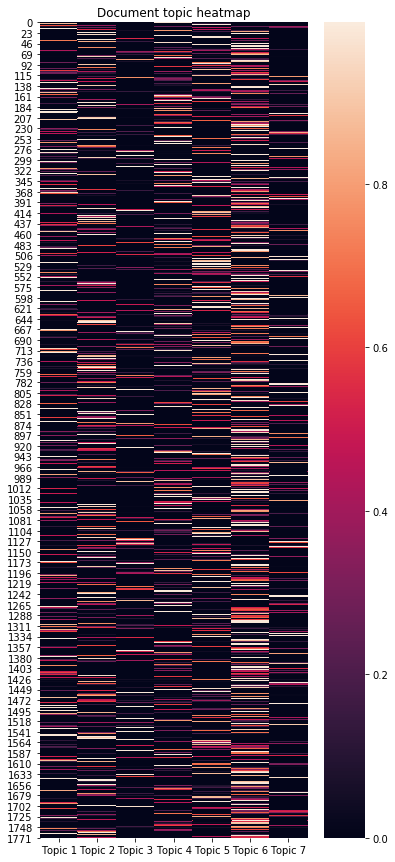

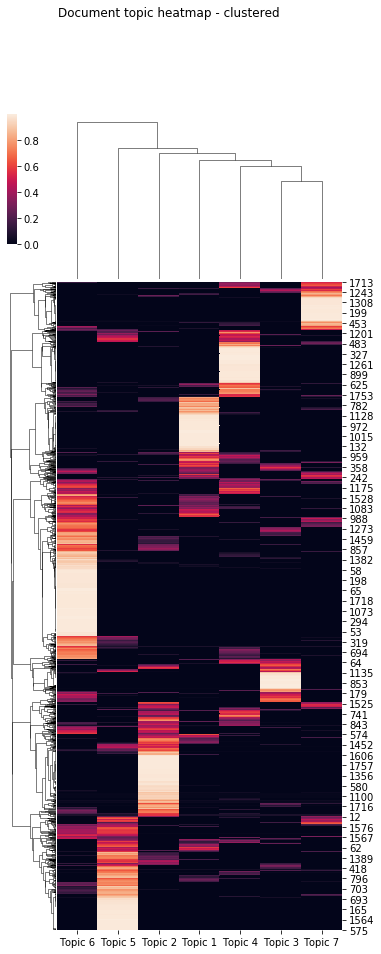

In [17]:
hm, cm = visualize(topic_vectors)

Visualize by time.

In [18]:
#datetime_data = get_datetime(topic_vectors, data)
#hm_t = heat_map_time('2000-01-01', '2010-12-31', datetime_data)

In [19]:
dominant_topic = get_dominant_topic(ldamodel, corpus, data)
dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,Title
0,0,0.0,0.5631,"system, user, process, present, software, info...",Text detection in natural images has gained mu...,An improved edge profile based method for text...
1,1,3.0,0.9877,"data, network, system, model, learning, decisi...",Ability to integrate legacy assets and reusing...,Improving mobile operator information system e...
2,2,4.0,0.5115,"learning, model, present, data, used, algorith...","Traditionally, sign languages used by the deaf...",Learning sign language through multimedia
3,3,0.0,0.8726,"system, user, process, present, software, info...",Education is a dominating application area for...,Fuzzy user modeling for adaptation in educatio...
4,4,4.0,0.8630,"learning, model, present, data, used, algorith...",The paper presents a method for visualizing da...,Visualization in machine learning
...,...,...,...,...,...,...
1777,1777,1.0,0.5023,"graph, data, approach, network, system, model,...",Data-driven intelligent tutoring systems learn...,Rewrite rules for debugging student programs i...
1778,1778,4.0,0.9915,"learning, model, present, data, used, algorith...",Bell chiming is a folk music tradition that in...,Automatic transcription of bell chiming record...
1779,1779,5.0,0.9937,"model, algorithm, data, approach, image, set, ...",Hardware multithreading is becoming a generall...,A survey of processors with explicit multithre...
1780,1780,2.0,0.7808,"patient, time, disease, pd, treatment, used, m...",Let B be a nilpotent matrix and suppose that i...,On pairs of commuting nilpotent matrices


In [20]:
representative_docs = get_representative_doc(dominant_topic)
representative_docs

,Document_No,Topic_Num,Topic_Perc_Contrib,Keywords,Text,Title
0,309,0.0,0.9967,"system, user, process, present, software, info...",If you understand others you are intelligent. ...,"Natural and machine learning, intelligence and..."
1,1229,1.0,0.9951,"graph, data, approach, network, system, model,...",Background: Matrix factorization is a well est...,Scalable non-negative matrix tri-factorization
2,1582,2.0,0.9970,"patient, time, disease, pd, treatment, used, m...",The ventral intermediate nucleus (VIM) of the ...,Connectivity derived thalamic segmentation in ...
3,1034,3.0,0.9957,"data, network, system, model, learning, decisi...",We study the problem of automatic generation o...,Planning smooth and obstacle-avoiding B-spline...
4,1564,4.0,0.9964,"learning, model, present, data, used, algorith...",Background: Acetic acid is one of the major in...,Polygenic analysis and targeted improvement of...
5,1350,5.0,0.9973,"model, algorithm, data, approach, image, set, ...",Ischemia is a condition which can lead to insu...,Multipass Algorithm for Detection of Transient...
6,1139,6.0,0.9977,"development, service, process, software, appli...",By integration of information systems using we...,Influence of security mechanisms on web servic...


In [21]:
topic_distribution = get_topic_distribution(dominant_topic, representative_docs)
topic_distribution

,Topic_Num,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"system, user, process, present, software, info...",229,0.1285
1.0,1.0,"graph, data, approach, network, system, model,...",264,0.1481
2.0,2.0,"patient, time, disease, pd, treatment, used, m...",109,0.0612
3.0,3.0,"data, network, system, model, learning, decisi...",227,0.1274
4.0,4.0,"learning, model, present, data, used, algorith...",307,0.1723
5.0,5.0,"model, algorithm, data, approach, image, set, ...",488,0.2738
6.0,6.0,"development, service, process, software, appli...",158,0.0887


## Time-based visualizations

Visualizing which topics were the most popular throughout the years. We first plot the distribution through time of the topics generated on the whole database. 

In [22]:
import plotly.graph_objects as go
import plotly.express as px

In [32]:
totals = []
means = []
x = []

for year in range(2003, 2020):
    indices = data.index[data['Date'] == year].tolist()
    
    total = len(indices)

    year_dominant_topic = dominant_topic[dominant_topic.index.isin(indices)]
    topic_count = year_dominant_topic['Dominant_Topic'].value_counts()
    
    t = []
    m = []
    
    for i in range(num_topics):
        try:
            t.append(topic_count[i])
            m.append(topic_count[i] / total)
        except:
            t.append(0)
            m.append(0)
        
    totals.append(t)
    means.append(m)
    x.append(year)
    
totals = np.array(totals).transpose()
means = np.array(means).transpose()

In [ ]:
fig = go.Figure()

for i in range(len(totals)):
    fig.add_trace(go.Scatter(x = x, y=totals[i],
                    mode='lines',
                    name='topic {:}'.format(i + 1)))
fig.show()

In [ ]:
fig = go.Figure()

for i in range(len(totals)):
    fig.add_trace(go.Scatter(x = x, y=means[i],
                    mode='lines',
                    name='topic {:}'.format(i + 1)))
fig.show()

What would be more interesting to see is, how are topics generated in a smaller time period represented in the whole database. For that we need a function that finds topics for an unseen document or a group of them.

`find_doc_topic` calculates the weights of the topics for every document in the dataframe `preprocessed_data`. We can change the number of topics (`no_outputs`) we want to return, the default value is only one topic, which is the one the model evaluated as the best. If we want the function to return only topics, which have a score higher than some value, we can set that value with the `threshold` parameter.

In [26]:
def find_doc_topic(ldamodel, dictionary, preprocessed_data, no_outputs=1, threshold=None):
    
    new_df = preprocessed_data.filter(['Title', 'Abstract', 'Date'], axis=1)
    
    topic_vectors = []
    
    # Create a set of tokens used in the smaller model. Using intersection is faster than comparing lists
    topic_tokens = set()
    for i in range(len(dictionary)):
        topic_tokens.add(dictionary[i])
        
    # Remove words which are not included in the topic_model corpus
    for i, row in preprocessed_data.iterrows():
        row['tokens'] = topic_tokens.intersection(set(row['tokens']))
        
    # create corpus for new documents with the ldamodel dictionary
    corpus = [dictionary.doc2bow(text) for text in preprocessed_data['tokens']]
    
    for i, row in enumerate(ldamodel[corpus]):
        arr = []
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j in range(min(no_outputs, len(row))):
            arr.append(row[j])
            
        topic_vectors.append(arr[0])
        
    if no_outputs == 1 and threshold is not None:
        for i in range(len(topic_vectors)):
            if topic_vectors[i][1] < threshold:
                topic_vectors[i] = (None, None)
                

    df = pd.DataFrame((topic_vectors), columns =['Topic', 'Topic_Weigth'])
    df = pd.concat([df, new_df], axis=1)
    
    
    return df

First we need to select the time period which will be used to generate topics. Then we select the data from the database, which falls into the selected time period and generate the topics with the LDA model.

In [28]:
startYear = 2017
endYear = 2019

topic_data = data.loc[(data['Date'] >= startYear) & (data['Date'] <= endYear)]

topic_documents_tokens, topic_data_preprocessed, topic_bigram_lexicon = preprocess(topic_data, to_ignore=ignore_words)

topic_corpus, topic_dictionary, topic_ldamodel = pyldavis_prep(topic_documents_tokens, num_topics=num_topics, num_words=num_words)

topic_vectors = add_topics_vector(topic_corpus, topic_ldamodel)
data_preprocessed_vectors = pd.concat([data_preprocessed, topic_vectors], axis=1)

Topic 1:
   "data": 0.016
   "system": 0.013
   "user": 0.008
   "network": 0.007
   "using": 0.006
   "visualization": 0.006
   "use": 0.005
   "model": 0.005
   "present": 0.005
   "different": 0.005
Topic 2:
   "image": 0.008
   "recognition": 0.008
   "group": 0.006
   "used": 0.006
   "ear": 0.005
   "using": 0.005
   "technology": 0.005
   "segmentation": 0.004
   "use": 0.004
   "dataset": 0.004
Topic 3:
   "model": 0.010
   "patient": 0.010
   "rule": 0.008
   "learning": 0.007
   "approach": 0.007
   "based": 0.006
   "student": 0.006
   "disease": 0.006
   "data": 0.006
   "system": 0.005
Topic 4:
   "model": 0.017
   "patient": 0.009
   "approach": 0.009
   "ear": 0.007
   "recognition": 0.007
   "image": 0.006
   "system": 0.005
   "data": 0.005
   "effect": 0.004
   "performance": 0.004
Topic 5:
   "data": 0.009
   "model": 0.006
   "tissue": 0.005
   "egfr": 0.005
   "approach": 0.005
   "system": 0.004
   "sensor": 0.004
   "difference": 0.004
   "small": 0.004
   "pd": 

In [29]:
dataFrame = find_doc_topic(topic_ldamodel, topic_dictionary, data_preprocessed, threshold=0.5)
year_groups = dataFrame.groupby(['Date', 'Topic']).size().reset_index(name='counts')

totals = []

start = int(year_groups['Date'].min())
stop = int(year_groups['Date'].max())

for year in range(start, stop + 1):
    year_group = year_groups[year_groups['Date'] == year]
    
    t = []
    
    for i in range(num_topics):
        if i in list(year_group['Topic']):
            t.append(int(year_group[year_group['Topic'] == i]['counts']))
        else:
            t.append(0)
            
    totals.append(t)

totals = np.array(totals).transpose()

Get descriptions of the topic, for the graph labels.

In [30]:
topic_text = []

for i in range(num_topics):
    words = []
    topic = topic_ldamodel.show_topic(i)
    for j in range(len(topic)):
        words.append(topic[j][0])
        
    topic_text.append(words)

The highlited zone on the plot shows the time period the data was taken from to generate the topics.

In [ ]:
fig = go.Figure()

for i in range(len(totals)):
    fig.add_trace(go.Scatter(x = list(range(start, stop+1)), y=totals[i],
                    mode='lines',
                    name=str(topic_text[i])))
    
fig.update_layout(legend_orientation="h")

fig.update_layout(
    shapes=[
        go.layout.Shape(
            type="rect",
            # x-reference is assigned to the x-values
            xref="x",
            # y-reference is assigned to the plot paper [0,1]
            yref="paper",
            x0=startYear,
            y0=0,
            x1=endYear,
            y1=1,
            fillcolor="LightSalmon",
            opacity=0.5,
            layer="below",
            line_width=0,
        )
    ]
)

fig.show()